# FLG cis comparison


## Step 1: Library Imports

Run this cell to import the necessary libraries

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats
import re
import sys 
#sys.path.append('C:\\Users\\brittany henderson\\GitHub\\GBM_for_CPTAC\\')
#import cis_functions as f

import cptac
import cptac.utils as u

In [2]:
def add_significance_col(results_df, num_comparisons):
    "bonferroni multiple hypothesis"""
    alpha = .05
    bonferroni_cutoff = alpha / num_comparisons
    
    pval = results_df['P_Value']
    if float(pval[0]) <= bonferroni_cutoff:
        results_df['Significant'] = True
    else: 
        results_df['Significant'] = False
    return results_df

def wrap_ttest_return_all(df, label_column, comparison_columns, total_tests, alpha=.05):
    try:
        #Verify precondition that label column exists and has exactly 2 unique values
        label_values = df[label_column].unique()
        if len(label_values) != 2:
            print("Incorrectly Formatted Dataframe! Label column must have exactly 2 unique values.")
            return None
        
        #Partition dataframe into two sets, one for each of the two unique values from the label column
        partition1 = df.loc[df[label_column] == label_values[0]]
        partition2 = df.loc[df[label_column] == label_values[1]]
        
        #Determine the number of real valued columns on which we will do t-tests
        #sites = len(comparison_columns.columns)
        number_of_comparisons = total_tests # ? phospho sites or num freq mut genes doing cis comp
        
        #Use a bonferroni correction to adjust for multiple testing by altering the p-value needed for acceptance
        bonferroni_cutoff = alpha/number_of_comparisons
        
        #Store all comparisons with their p-values in a dictionary
        all_comparisons = {}
        
        #Loop through each comparison column, perform the t-test, and determine whether it meets the significance cutoff'''
        for column in comparison_columns:
            stat, pval = scipy.stats.ttest_ind(partition1[column].dropna(axis=0), partition2[column].dropna(axis=0))
            all_comparisons[column] = pval
    
        #Sort dictionary to list smallest p-values first
        sorted_comparisons = sorted(all_comparisons.items(), key=lambda kv: kv[1])
        #Format as a dataframe and return to caller
        all_comparisons_df = pd.DataFrame.from_dict(sorted_comparisons)
        all_comparisons_df.columns = ['Comparison', 'P_Value']
        
                                               
        all_comparisons_sig_col = add_significance_col(all_comparisons_df, number_of_comparisons)
        return all_comparisons_sig_col
                                
    except:
        print("Incorrectly Formatted Dataframe!")
        return None


In [3]:
# note: pass reduced omics # CHECK would include non coding, but none in fm genes

def format_mutated_wt_comparison(reduced_omics_df):
    # Step 2 - Create binary column 
    reduced_omics_df['binary_mutations'] = np.where(
                reduced_omics_df[gene+'_Mutation_Status'] == 'Wildtype_Tumor', 'Wildtype', 'Mutated')

    # Step 3 - Format the dataframe correctly for the T-test(just omics and binary columns for tumors)
    tumors = reduced_omics_df[reduced_omics_df.Sample_Status == 'Tumor'] #drop Normal samples
    columns_to_drop = [gene+"_Mutation", gene+"_Location", gene+"_Mutation_Status", "Sample_Status"]
    mut_status = tumors.drop(columns_to_drop, axis = 1)

    return mut_status

In [4]:
def get_missense_truncation_comparison(cancer_object, reduced_omics_df):
    #get omics data and tumors
    tumors = reduced_omics_df.loc[reduced_omics_df['Sample_Status'] == 'Tumor'] #drop Normal samples


    somatic_mutations = cancer_object.get_somatic_mutation().reset_index()

    if cancer_object.get_cancer_type() == 'colon':
        missence_truncation_groups = {'frameshift substitution': 'Truncation', 
            'frameshift deletion': 'Truncation', 'frameshift insertion': 'Truncation', 
            'stopgain': 'Truncation', 'stoploss': 'Truncation', 'nonsynonymous SNV': 'Missense',
            'nonframeshift insertion': 'Missense','nonframeshift deletion': 'Missense', 
            'nonframeshift substitution': 'Missense'}
    else: 
        missence_truncation_groups = {'In_Frame_Del': 'Missense', 'In_Frame_Ins': 'Missense',
            'Missense_Mutation': 'Missense', 'Frame_Shift_Del': 'Truncation','Nonsense_Mutation': 'Truncation', 
            'Splice_Site': 'Truncation', 'Frame_Shift_Ins': 'Truncation','Nonstop_Mutation':'Truncation'}

    mutations_replaced_M_T = somatic_mutations.replace(missence_truncation_groups)
    mutations_replaced_M_T = mutations_replaced_M_T.loc[mutations_replaced_M_T['Gene'] == gene]

    # group mutation categories
    miss = mutations_replaced_M_T.loc[mutations_replaced_M_T['Mutation'] == 'Missense']
    trunc = mutations_replaced_M_T.loc[mutations_replaced_M_T['Mutation'] == 'Truncation']

    #get lists of unique samples for missence and trucation categories
    miss_unique_samples = list(miss['Sample_ID'].unique())
    trunc_unique_samples = list(trunc['Sample_ID'].unique())
    
    #check if there is only one type of mutation for the specific gene
    if miss_unique_samples == []:
        print('Only truncation type mutations found for', gene+'.', 
             'Not possible to compare missense with wildtype.')
        truncation_omics = tumors.loc[tumors.index.isin(trunc_unique_samples)]
        truncation_omics = truncation_omics.assign(binary_mutations = 'Truncation')
        columns_to_drop = [gene+"_Mutation", gene+"_Location", gene+"_Mutation_Status", "Sample_Status"]
        binary_mut_omics = truncation_omics.drop(columns_to_drop, axis = 1)
        return binary_mut_omics
    elif trunc_unique_samples == []:
        print('Only missence type mutations found for', gene+'.', 
             'Not possible to compare truncation with wildtype.')
        missence_omics = tumors.loc[tumors.index.isin(miss_unique_samples)]
        missence_omics = missence_omics.assign(binary_mutations = 'Missense')
        columns_to_drop = [gene+"_Mutation", gene+"_Location", gene+"_Mutation_Status", "Sample_Status"]
        binary_mut_omics = missence_omics.drop(columns_to_drop, axis = 1)
        return binary_mut_omics

    ### Step 2 - Create the binary column needed to do the comparison
    # Get mutation catagories with omics data
    missence_omics = tumors.loc[tumors.index.isin(miss_unique_samples)]
    missence_omics = missence_omics.assign(binary_mutations = 'Missense')
    truncation_omics = tumors.loc[tumors.index.isin(trunc_unique_samples)]
    truncation_omics = truncation_omics.assign(binary_mutations = 'Truncation')
    binary_mut_omics = missence_omics.append(truncation_omics)

    # Step 3 - Format the dataframe correctly for the T-test(just omics and binary columns for tumors)
    columns_to_drop = [gene+"_Mutation", gene+"_Location", gene+"_Mutation_Status", "Sample_Status"]
    binary_mut_omics = binary_mut_omics.drop(columns_to_drop, axis = 1)

    return binary_mut_omics


In [5]:
def format_pval_annotation(pval_symbol, x1, x2, line_start = .05, line_height=.05):
    # for manual adjustment to pval annotations
    
    y, h = line_start, line_height
    plt.plot([x1, x1, x2, x2], #draw horizontal line
             [y, y+h, y+h, y], #vertical line
             lw=1.5, color= '.3')
    plt.text((x1+x2)*.5, # half between x coord
             y+h, pval_symbol, horizontalalignment='center', verticalalignment='bottom', color = "black")

# used in pval_annotation
def get_pval_symbol(pval_df):
    if pval_df.iloc[0:,2].bool() == True:
        pval_symbol = '*'
    else:
        pval_symbol = 'ns'
    return pval_symbol

def pval_annotation(pval_df, plotted_df):
    # pval symbol
    num_pvals = len(pval_df)
    omics_col = plotted_df.columns[0]
    

    # annotation for Mutated and Wiltype
    if num_pvals == 1:
        mut_pval = pval_df.loc[pval_df.index == "Mutated/Wildtype"]
        mut_pval_symbol = get_pval_symbol(pval_df)
        
        x1, x2 = 0, 1   # columns (first column: 0, see plt.xticks())
        y, h = plotted_df[omics_col].max() + .05, .05     
        plt.plot([x1, x1, x2, x2], #draw horizontal line
                 [y, y+h, y+h, y], #vertical line
                 lw=1.5, color= '.3')
        plt.text((x1+x2)*.5, # half between x coord
                 y+h, mut_pval_symbol, horizontalalignment='center', verticalalignment='bottom', color = "black")
    
    # annotation for Missense, Truncation and Wildtype
    elif num_pvals == 2:
        # Missense
        miss_pval = pval_df.loc[pval_df.index == "Missense/Wildtype"]
        miss_pval_symbol = get_pval_symbol(miss_pval)
    
        x1, x2 = 0, 1   # columns (first column: 0, see plt.xticks())
        y, h = plotted_df[omics_col].max() + .05, .05     
        plt.plot([x1, x1, x2, x2], #draw horizontal line
                 [y, y+h, y+h, y], #vertical line
                 lw=1.5, color= '.3')
        plt.text((x1+x2)*.5, # half between x coord
                 y+h, miss_pval_symbol, horizontalalignment='center', verticalalignment='bottom', color = "black")
        
        # Truncation 
        trunc_pval = pval_df.loc[pval_df.index == "Truncation/Wildtype"]
        trunc_pval_symbol = get_pval_symbol(trunc_pval)
        
        x3, x4 = 0, 2   # columns (first column: 0, see plt.xticks())
        y2, h2 = plotted_df[omics_col].max() + .15, .05     
        plt.plot([x3, x3, x4, x4], #draw horizontal line
                 [y2, y2+h2, y2+h2, y2], #vertical line
                 lw=1.5, color= '.3')
        plt.text((x3+x4)*.5, # half between x coord
                 y2+h2, trunc_pval_symbol, horizontalalignment='center', verticalalignment='bottom', color = "black")


## Step 2: Find the mutation frequency of the gene of interest

In [6]:
#cptac.download(dataset='ccrcc', version='0.0')
brain = cptac.Gbm()
desired_cutoff = 0.05
gene = 'FLG'

In [7]:
#FIX
#freq_mut = u.get_frequently_mutated(brain, cutoff = desired_cutoff)
#freq_mut.loc[freq_mut['Gene'] == gene]

## Step 3: cis comparisons for omics 

Determine if the DNA mutation has an effect on the omics measurement. In order to do this, we have a few steps in code. These steps are found in the format_cis_comparison_data function.
1. get a table with both the omics and mutation data for tumors
2. get a binary column from the mutation data to separate our samples
3. format data frame to be used in the T-test
4. send data to the T-test.

The format_cis_comparison_data does the first 3 steps (for dataframes with multi-indexes).

# Transcriptomics cis comparison

Transcriptomics: Mutated and Wildtype

In [8]:
#num_freq_mut_genes = len(freq_mut)
num_freq_mut_genes = 20
# Step 1 - Create dataframe in order to do comparisons with wrap_ttest - drop 
transrcpt_mutations = brain.join_omics_to_mutations(
    mutations_genes = gene, omics_df_name = 'transcriptomics', omics_genes = gene)
reduced_transcript_mutations = brain.reduce_multiindex(transrcpt_mutations, levels_to_drop=1) #single col labels

# Step 2 & 3 - Get binary column and format
transcript_mut_wt = format_mutated_wt_comparison(reduced_transcript_mutations)

In [9]:
# Step 4 - T-test
trans_col_list = [gene+'_transcriptomics']
trans_col = gene+'_transcriptomics'

print("Doing t-test comparison for mutation status")
transcript_results = wrap_ttest_return_all(transcript_mut_wt, 'binary_mutations', trans_col_list, num_freq_mut_genes)
transcript_results = transcript_results.rename(index = {0: "Mutated/Wildtype"})
transcript_results

Doing t-test comparison for mutation status


,Comparison,P_Value,Significant
Mutated/Wildtype,FLG_transcriptomics,0.394928,False


Multiple hypothesis testing is taken into account. Other notebooks test the rest of the frequently mutated genes. 

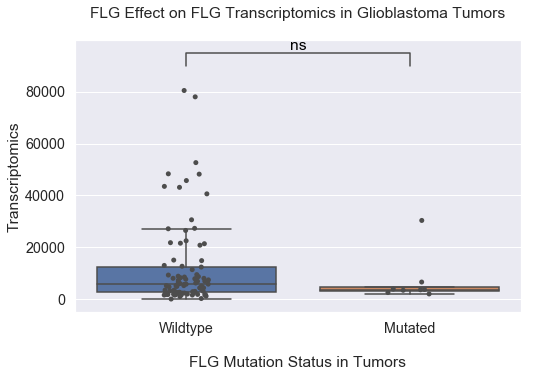

In [19]:
#f.cis_plot(trans_mut_status, gene, 'transcriptomics', transcrpt_results)
plt.rcParams['figure.figsize']=(8,5)
sns.set(font_scale = 1.3)
cis_boxplot = sns.boxplot(data = transcript_mut_wt, x = 'binary_mutations',
                          y = trans_col, order = ['Wildtype', 'Mutated'], showfliers = False)  
cis_boxplot.set_title(gene + " Effect on " + gene +" Transcriptomics in Glioblastoma Tumors\n")
cis_boxplot = sns.stripplot(data= transcript_mut_wt, x = 'binary_mutations',
                            y = trans_col,jitter = True, color = ".3", order = ['Wildtype', 'Mutated'])
cis_boxplot.set(xlabel = "\n"+gene + " Mutation Status in Tumors", ylabel = 'Transcriptomics')
cis_boxplot.set_xticklabels(cis_boxplot.get_xticklabels())

mut_pval_symbol = get_pval_symbol(transcript_results)
format_pval_annotation(mut_pval_symbol, x1 = 0, x2 = 1, line_start = 90000, line_height = 5000)

plt.show()
plt.clf()
plt.close()

Transcriptomics: Missense and Truncation

In [22]:
# select all wildtype from earlier -add to mut_type binary column
trans_wildtype = transcript_mut_wt.loc[transcript_mut_wt['binary_mutations'] == 'Wildtype'] 
trans_miss_trunc = get_missense_truncation_comparison(brain, reduced_transcript_mutations)
trans_miss_trunc_and_wt = trans_miss_trunc.append(trans_wildtype, sort=False) # use for graph
trans_miss_trunc_and_wt['binary_mutations'].value_counts()

Only missence type mutations found for FLG. Not possible to compare truncation with wildtype.


In [24]:
# compare missense and wildtype
miss_wt = trans_miss_trunc_and_wt.loc[trans_miss_trunc_and_wt['binary_mutations'] != 'Truncation']
print("Doing t-test comparison for missense and wildtype")
trans_results_miss = wrap_ttest_return_all(miss_wt, 'binary_mutations', trans_col_list, num_freq_mut_genes)
trans_results_miss = trans_results_miss.rename(index = {0: "Missense/Wildtype"})

# No truncation mutations

trans_results_miss_trunc = trans_results_miss
trans_results_miss_trunc

Doing t-test comparison for missense and wildtype


,Comparison,P_Value,Significant
Missense/Wildtype,FLG_transcriptomics,0.571669,False


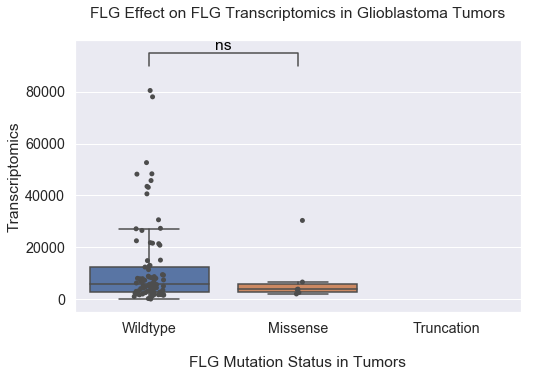

In [28]:
#f.cis_plot(trans_mut_and_wildtype, gene, 'transcriptomics', trans_results_miss_trunc)
plt.rcParams['figure.figsize']=(8,5)
sns.set(font_scale = 1.3)
cis_boxplot = sns.boxplot(data = trans_miss_trunc_and_wt, x = 'binary_mutations',
                          y = trans_col, order = ['Wildtype', 'Missense', 'Truncation'], showfliers = False)  
cis_boxplot.set_title(gene + " Effect on " + gene +" Transcriptomics in Glioblastoma Tumors\n")
cis_boxplot = sns.stripplot(data= trans_miss_trunc_and_wt, x = 'binary_mutations',
                            y = trans_col,jitter = True, color = ".3", order = ['Wildtype', 'Missense', 'Truncation'])
cis_boxplot.set(xlabel = "\n"+gene + " Mutation Status in Tumors", ylabel = 'Transcriptomics')
cis_boxplot.set_xticklabels(cis_boxplot.get_xticklabels())

# Missense
miss_pval = trans_results_miss_trunc.loc[trans_results_miss_trunc.index == "Missense/Wildtype"]
miss_pval_symbol = get_pval_symbol(miss_pval)
format_pval_annotation(miss_pval_symbol, x1 = 0, x2 = 1, line_start = 90000, line_height = 5000)

plt.show()
plt.clf()
plt.close()

# Proteomics cis comparison

Proteomics: Mutated and Wildtype

In [36]:
# Step 1 - Create dataframe in order to do comparisons with wrap_ttest  
prot_and_mutations = brain.join_omics_to_mutations(
    mutations_genes = gene, omics_df_name = 'proteomics', omics_genes = gene) # single col level


# Step 2 & 3 - Get binary column and format
prot_mut_wt = format_mutated_wt_comparison(prot_and_mutations)

In [37]:
#num_freq_mut_genes = len(freq_mut) 
num_freq_mut_genes = 20
prot_col_list = [gene+'_proteomics']
prot_col = gene+"_proteomics"

# Step 4 - T-test comparing means of mutated vs wildtype effect on cis omics
print("Doing t-test comparison for mutated and wildtype")
prot_results = wrap_ttest_return_all(prot_mut_wt, 'binary_mutations', prot_col_list, num_freq_mut_genes)
prot_results = prot_results.rename(index = {0: "Mutated/Wildtype"})
prot_results

Doing t-test comparison for mutated and wildtype


,Comparison,P_Value,Significant
Mutated/Wildtype,FLG_proteomics,NaN,False


No data for mutations in FLG in proteomics. 

# Phosphoproteomics cis comparison

Phosphoproteomics: Mutated and Wildtype

In [57]:
# Step 1 - Create dataframe in order to do comparisons with wrap_ttest
phospho_and_mut = brain.join_omics_to_mutations(
    mutations_genes = gene, omics_df_name = 'phosphoproteomics', omics_genes = gene)
flatten_phospho_and_mut = brain.reduce_multiindex(phospho_and_mut, levels_to_drop=1, flatten=True)#reduce multi columns

# Step 2 - Create the binary column needed to do the comparison
flatten_phospho_and_mut['binary_mutations'] = flatten_phospho_and_mut[gene+'_Mutation_Status'].apply(
    lambda x: 'Wildtype' if x == 'Wildtype_Tumor' else 'Mutated')

# Step 3 - Format
phospho_tumors = flatten_phospho_and_mut.query('Sample_Status != "Normal"') # drop Normal samples (warning with .loc)
columns_to_drop = [gene+"_Mutation", gene+"_Location", gene+"_Mutation_Status", "Sample_Status"]
binary_phospho = phospho_tumors.drop(columns_to_drop, axis = 1)
only_phospho = binary_phospho.drop('binary_mutations', axis = 1)

In [43]:
# Use al.wrap_ttest for many columns of phospho data (takes phospho sites into account with bonferroni cutoff)
phos_col_list = list(only_phospho.columns)

# Step 4 - T-test comparing means of mutated vs wildtype effect on cis omics
print("Doing t-test comparison for mutation status")
phos_pval_results = u.wrap_ttest(binary_phospho, 'binary_mutations', phos_col_list)
#phos_pval_results = phos_pval_results.rename(index = {0: "Mutated/Wildtype"})
phos_pval_results

Doing t-test comparison for mutation status
No significant comparisons.


Graph

In [45]:
# Create data frame with all significant phospho sites in order to graph
#phospho_list = list(phos_pval_results['Comparison']) # comment when no sig phospho sites
phospho_list = list(only_phospho.columns) # uncomment when no sig phospho sites
phospho_df = pd.melt(binary_phospho, id_vars = 'binary_mutations', 
            value_vars = phospho_list, var_name = 'specific_phospho', value_name = 'phosphoproteomics')
phospho_df.replace(to_replace = '_phosphoproteomics', value = '', 
                        inplace = True, regex = True) # shorten column names

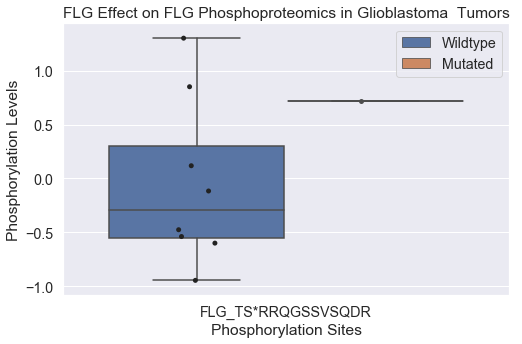

In [48]:
plt.rcParams['figure.figsize']=(8,5) #size of plot
sns.set(font_scale = 1.3)

cis_boxplot = sns.boxplot(data = phospho_df, x = 'specific_phospho', y = 'phosphoproteomics', hue = 'binary_mutations',
                             hue_order = ["Wildtype","Mutated"], showfliers = False) 
cis_boxplot.set_title(gene + " Effect on " + gene + " Phosphoproteomics in Glioblastoma  Tumors")
cis_boxplot = sns.stripplot(data = phospho_df, x = 'specific_phospho', y = 'phosphoproteomics', hue = 'binary_mutations',
                               hue_order = ["Wildtype","Mutated"], jitter = True, color = ".3", dodge = True)
cis_boxplot.set(xlabel = 'Phosphorylation Sites', ylabel = "Phosphorylation Levels")
cis_boxplot.set_xticklabels(cis_boxplot.get_xticklabels())

# format legend
handles, labels = cis_boxplot.get_legend_handles_labels()
plt.legend(handles[0:2], labels[0:2])

plt.show()
plt.clf()
plt.close()


Phosphoproteomics: Missense and Truncation

In [49]:
# select all wildtype from earlier -add to mut_type binary column
phos_wildtype = binary_phospho.loc[binary_phospho['binary_mutations'] == 'Wildtype'] 

phos_mut_type = get_missense_truncation_comparison(brain, flatten_phospho_and_mut)
phos_mut_and_wildtype = phos_mut_type.append(phos_wildtype, sort=True) 

Only missence type mutations found for FLG. Not possible to compare truncation with wildtype.


In [58]:
phos_col_list = list(only_phospho.columns)
# compare missense and wildtype
miss_wt = phos_mut_and_wildtype.loc[phos_mut_and_wildtype['binary_mutations'] != 'Truncation']
print("Doing t-test comparison for missense and wildtype\n")
phos_results_miss = u.wrap_ttest(miss_wt, 'binary_mutations', phos_col_list)
print(phos_results_miss)

Doing t-test comparison for missense and wildtype

No significant comparisons.
None


Graph Missense and Truncation

In [52]:
# Create data frame with all significant phospho sites in order to graph
#mut_type_phospho_list = list(phos_results_trunc['Comparison']) # comment when no sig phospho sites
mut_type_phospho_list = list(only_phospho.columns) # uncomment when no sig phospho sites
phos_mut_type_df = pd.melt(phos_mut_and_wildtype, id_vars = 'binary_mutations', 
            value_vars = mut_type_phospho_list, var_name = 'specific_phospho', value_name = 'phosphoproteomics')
phos_mut_type_df.replace(to_replace = '_phosphoproteomics', value = '', 
                        inplace = True, regex = True) # shorten column names

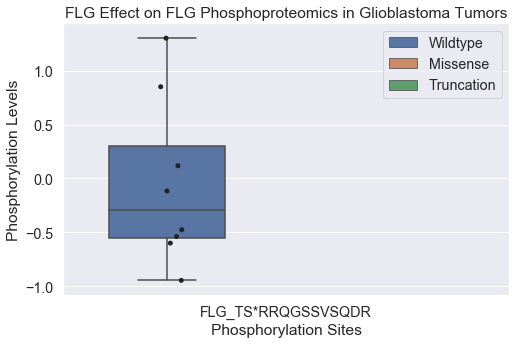

In [55]:
plt.rcParams['figure.figsize']=(8,5) #size of plot
sns.set(font_scale = 1.3)
phos_cis_boxplot = sns.boxplot(data = phos_mut_type_df, x = 'specific_phospho', y = 'phosphoproteomics', hue = 'binary_mutations',
                             hue_order = ["Wildtype","Missense","Truncation"], showfliers = False)  
phos_cis_boxplot.set_title(gene + " Effect on " + gene + " Phosphoproteomics in Glioblastoma Tumors")
phos_cis_boxplot = sns.stripplot(data = phos_mut_type_df, x = 'specific_phospho', y = 'phosphoproteomics', hue = 'binary_mutations',
                               hue_order = ["Wildtype","Missense","Truncation"], jitter = True, color = ".3", dodge = True)
phos_cis_boxplot.set(xlabel = 'Phosphorylation Sites', ylabel = "Phosphorylation Levels")
phos_cis_boxplot.set_xticklabels(phos_cis_boxplot.get_xticklabels())

# format legend
handles, labels = phos_cis_boxplot.get_legend_handles_labels()
plt.legend(handles[0:3], labels[0:3])


plt.show()
plt.clf()
plt.close()

# Results

Acetylproteomics not included in the Gbm dataset.